In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 1]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(2, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Dislike_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/value/GlamDataFF2018_Like_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i+1 for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-5, 5))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(ts_df[['rt', 'choice']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(4357, 5) (2932, 5)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):
    ndt = tf.convert_to_tensor([min_rt[i]*tf.math.sigmoid(model.layers[-1].weights[-1][i-1]) for i in tr_df['sbj']])
    thr = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-2][i-1])) for i in tr_df['sbj']])
    scl = tf.convert_to_tensor([tf.math.log(1 + tf.exp(model.layers[-1].weights[-3][i-1])) for i in tr_df['sbj']])
    
    ll1 = (1 - obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (obs_train[:, 1]) * fpt(obs_train[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(obs_train[:, 0]-ndt, thr, scl*pred[:, 0]))
    
    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 111       
                                                                 
Total params: 479 (1.87 KB)
Trainable params: 479 (1.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 136s 136s/step - loss: 35846.4062
Epoch 2/3500
1/1 [==============================] - 0s 58ms/step - loss: 35656.6250
Epoch 3/3500
1/1 [==============================] - 0s 34ms/step - loss: 35522.9023
Epoch 4/3500
1/1 [==============================] - 0s 33ms/step - loss: 35411.6719
Epoch 5/3500
1/1 [==============================] - 0s 33ms/step - loss: 35312.9219
Epoch 6/3500
1/1 [==============================] - 0s 37ms/step - loss: 35222.2422
Epoch 7/3500
1/1 [==============================] - 0s 39ms/step - loss: 35137.2109
Epoch 8/3500
1/1 [==============================] - 0s 34ms/step - loss: 35056.3516
Epoch 9/3500
1/1 [==============================] - 0s 45ms/step - loss: 34978.6719
Epoch 10/3500
1/1 [==============================] - 0s 34ms/step - loss: 34903.4688
Epoch 11/3500
1/1 [==============================] - 0s 34ms/step - loss: 34830.2422
Epoch 12/3500
1/1 [==============================] - 0s 34ms/step - loss

1/1 [==============================] - 0s 48ms/step - loss: 30210.0410
Epoch 98/3500
1/1 [==============================] - 0s 49ms/step - loss: 30175.6719
Epoch 99/3500
1/1 [==============================] - 0s 45ms/step - loss: 30141.6719
Epoch 100/3500
1/1 [==============================] - 0s 45ms/step - loss: 30108.0273
Epoch 101/3500
1/1 [==============================] - 0s 43ms/step - loss: 30074.7383
Epoch 102/3500
1/1 [==============================] - 0s 44ms/step - loss: 30041.7969
Epoch 103/3500
1/1 [==============================] - 0s 45ms/step - loss: 30009.1992
Epoch 104/3500
1/1 [==============================] - 0s 47ms/step - loss: 29976.9375
Epoch 105/3500
1/1 [==============================] - 0s 45ms/step - loss: 29945.0098
Epoch 106/3500
1/1 [==============================] - 0s 46ms/step - loss: 29913.4102
Epoch 107/3500
1/1 [==============================] - 0s 44ms/step - loss: 29882.1289
Epoch 108/3500
1/1 [==============================] - 0s 45ms/step - lo

1/1 [==============================] - 0s 44ms/step - loss: 27992.8281
Epoch 193/3500
1/1 [==============================] - 0s 45ms/step - loss: 27976.3359
Epoch 194/3500
1/1 [==============================] - 0s 46ms/step - loss: 27959.9277
Epoch 195/3500
1/1 [==============================] - 0s 44ms/step - loss: 27943.5977
Epoch 196/3500
1/1 [==============================] - 0s 46ms/step - loss: 27927.3496
Epoch 197/3500
1/1 [==============================] - 0s 47ms/step - loss: 27911.1797
Epoch 198/3500
1/1 [==============================] - 0s 45ms/step - loss: 27895.0898
Epoch 199/3500
1/1 [==============================] - 0s 45ms/step - loss: 27879.0781
Epoch 200/3500
1/1 [==============================] - 0s 46ms/step - loss: 27863.1406
Epoch 201/3500
1/1 [==============================] - 0s 44ms/step - loss: 27847.2793
Epoch 202/3500
1/1 [==============================] - 0s 48ms/step - loss: 27831.4883
Epoch 203/3500
1/1 [==============================] - 0s 47ms/step - 

1/1 [==============================] - 0s 48ms/step - loss: 26685.2969
Epoch 288/3500
1/1 [==============================] - 0s 46ms/step - loss: 26673.4766
Epoch 289/3500
1/1 [==============================] - 0s 45ms/step - loss: 26661.6836
Epoch 290/3500
1/1 [==============================] - 0s 45ms/step - loss: 26649.9219
Epoch 291/3500
1/1 [==============================] - 0s 45ms/step - loss: 26638.1836
Epoch 292/3500
1/1 [==============================] - 0s 42ms/step - loss: 26626.4766
Epoch 293/3500
1/1 [==============================] - 0s 43ms/step - loss: 26614.7930
Epoch 294/3500
1/1 [==============================] - 0s 44ms/step - loss: 26603.1406
Epoch 295/3500
1/1 [==============================] - 0s 45ms/step - loss: 26591.5098
Epoch 296/3500
1/1 [==============================] - 0s 43ms/step - loss: 26579.9102
Epoch 297/3500
1/1 [==============================] - 0s 44ms/step - loss: 26568.3320
Epoch 298/3500
1/1 [==============================] - 0s 43ms/step - 

1/1 [==============================] - 0s 44ms/step - loss: 25661.9922
Epoch 383/3500
1/1 [==============================] - 0s 43ms/step - loss: 25652.0781
Epoch 384/3500
1/1 [==============================] - 0s 44ms/step - loss: 25642.1797
Epoch 385/3500
1/1 [==============================] - 0s 44ms/step - loss: 25632.2969
Epoch 386/3500
1/1 [==============================] - 0s 45ms/step - loss: 25622.4297
Epoch 387/3500
1/1 [==============================] - 0s 44ms/step - loss: 25612.5762
Epoch 388/3500
1/1 [==============================] - 0s 44ms/step - loss: 25602.7383
Epoch 389/3500
1/1 [==============================] - 0s 43ms/step - loss: 25592.9141
Epoch 390/3500
1/1 [==============================] - 0s 42ms/step - loss: 25583.1016
Epoch 391/3500
1/1 [==============================] - 0s 43ms/step - loss: 25573.3047
Epoch 392/3500
1/1 [==============================] - 0s 43ms/step - loss: 25563.5234
Epoch 393/3500
1/1 [==============================] - 0s 42ms/step - 

1/1 [==============================] - 0s 59ms/step - loss: 24778.7383
Epoch 478/3500
1/1 [==============================] - 0s 60ms/step - loss: 24770.0078
Epoch 479/3500
1/1 [==============================] - 0s 54ms/step - loss: 24761.2910
Epoch 480/3500
1/1 [==============================] - 0s 52ms/step - loss: 24752.5840
Epoch 481/3500
1/1 [==============================] - 0s 50ms/step - loss: 24743.8906
Epoch 482/3500
1/1 [==============================] - 0s 59ms/step - loss: 24735.2070
Epoch 483/3500
1/1 [==============================] - 0s 60ms/step - loss: 24726.5332
Epoch 484/3500
1/1 [==============================] - 0s 55ms/step - loss: 24717.8672
Epoch 485/3500
1/1 [==============================] - 0s 77ms/step - loss: 24709.2148
Epoch 486/3500
1/1 [==============================] - 0s 57ms/step - loss: 24700.5742
Epoch 487/3500
1/1 [==============================] - 0s 53ms/step - loss: 24691.9434
Epoch 488/3500
1/1 [==============================] - 0s 51ms/step - 

1/1 [==============================] - 0s 49ms/step - loss: 23985.9102
Epoch 573/3500
1/1 [==============================] - 0s 48ms/step - loss: 23977.9062
Epoch 574/3500
1/1 [==============================] - 0s 49ms/step - loss: 23969.8867
Epoch 575/3500
1/1 [==============================] - 0s 54ms/step - loss: 23961.8906
Epoch 576/3500
1/1 [==============================] - 0s 54ms/step - loss: 23953.8867
Epoch 577/3500
1/1 [==============================] - 0s 52ms/step - loss: 23945.9023
Epoch 578/3500
1/1 [==============================] - 0s 49ms/step - loss: 23937.9062
Epoch 579/3500
1/1 [==============================] - 0s 47ms/step - loss: 23929.9297
Epoch 580/3500
1/1 [==============================] - 0s 51ms/step - loss: 23921.9434
Epoch 581/3500
1/1 [==============================] - 0s 49ms/step - loss: 23913.9785
Epoch 582/3500
1/1 [==============================] - 0s 44ms/step - loss: 23906.0000
Epoch 583/3500
1/1 [==============================] - 0s 44ms/step - 

1/1 [==============================] - 0s 50ms/step - loss: 23146.4238
Epoch 668/3500
1/1 [==============================] - 0s 48ms/step - loss: 23136.4199
Epoch 669/3500
1/1 [==============================] - 0s 43ms/step - loss: 23126.3984
Epoch 670/3500
1/1 [==============================] - 0s 43ms/step - loss: 23116.3613
Epoch 671/3500
1/1 [==============================] - 0s 42ms/step - loss: 23106.3047
Epoch 672/3500
1/1 [==============================] - 0s 41ms/step - loss: 23096.2324
Epoch 673/3500
1/1 [==============================] - 0s 41ms/step - loss: 23086.1445
Epoch 674/3500
1/1 [==============================] - 0s 47ms/step - loss: 23076.0391
Epoch 675/3500
1/1 [==============================] - 0s 43ms/step - loss: 23065.9219
Epoch 676/3500
1/1 [==============================] - 0s 43ms/step - loss: 23055.7891
Epoch 677/3500
1/1 [==============================] - 0s 42ms/step - loss: 23045.6445
Epoch 678/3500
1/1 [==============================] - 0s 41ms/step - 

1/1 [==============================] - 0s 43ms/step - loss: 22311.3184
Epoch 763/3500
1/1 [==============================] - 0s 41ms/step - loss: 22304.0430
Epoch 764/3500
1/1 [==============================] - 0s 42ms/step - loss: 22296.7383
Epoch 765/3500
1/1 [==============================] - 0s 41ms/step - loss: 22289.4844
Epoch 766/3500
1/1 [==============================] - 0s 44ms/step - loss: 22282.2051
Epoch 767/3500
1/1 [==============================] - 0s 43ms/step - loss: 22274.9844
Epoch 768/3500
1/1 [==============================] - 0s 42ms/step - loss: 22267.7344
Epoch 769/3500
1/1 [==============================] - 0s 42ms/step - loss: 22260.5391
Epoch 770/3500
1/1 [==============================] - 0s 42ms/step - loss: 22253.3301
Epoch 771/3500
1/1 [==============================] - 0s 43ms/step - loss: 22246.1719
Epoch 772/3500
1/1 [==============================] - 0s 77ms/step - loss: 22238.9961
Epoch 773/3500
1/1 [==============================] - 0s 44ms/step - 

1/1 [==============================] - 0s 44ms/step - loss: 21653.8906
Epoch 858/3500
1/1 [==============================] - 0s 43ms/step - loss: 21647.1016
Epoch 859/3500
1/1 [==============================] - 0s 46ms/step - loss: 21640.3555
Epoch 860/3500
1/1 [==============================] - 0s 44ms/step - loss: 21633.5664
Epoch 861/3500
1/1 [==============================] - 0s 44ms/step - loss: 21626.8164
Epoch 862/3500
1/1 [==============================] - 0s 43ms/step - loss: 21620.0312
Epoch 863/3500
1/1 [==============================] - 0s 43ms/step - loss: 21613.2773
Epoch 864/3500
1/1 [==============================] - 0s 43ms/step - loss: 21606.4922
Epoch 865/3500
1/1 [==============================] - 0s 42ms/step - loss: 21599.7383
Epoch 866/3500
1/1 [==============================] - 0s 44ms/step - loss: 21592.9531
Epoch 867/3500
1/1 [==============================] - 0s 42ms/step - loss: 21586.1992
Epoch 868/3500
1/1 [==============================] - 0s 42ms/step - 

1/1 [==============================] - 0s 45ms/step - loss: 20995.4180
Epoch 953/3500
1/1 [==============================] - 0s 47ms/step - loss: 20988.1328
Epoch 954/3500
1/1 [==============================] - 0s 45ms/step - loss: 20980.8203
Epoch 955/3500
1/1 [==============================] - 0s 44ms/step - loss: 20973.5078
Epoch 956/3500
1/1 [==============================] - 0s 47ms/step - loss: 20966.1680
Epoch 957/3500
1/1 [==============================] - 0s 49ms/step - loss: 20958.8281
Epoch 958/3500
1/1 [==============================] - 0s 50ms/step - loss: 20951.4609
Epoch 959/3500
1/1 [==============================] - 0s 48ms/step - loss: 20944.0938
Epoch 960/3500
1/1 [==============================] - 0s 53ms/step - loss: 20936.6953
Epoch 961/3500
1/1 [==============================] - 0s 48ms/step - loss: 20929.2969
Epoch 962/3500
1/1 [==============================] - 0s 51ms/step - loss: 20921.8672
Epoch 963/3500
1/1 [==============================] - 0s 50ms/step - 

1/1 [==============================] - 0s 43ms/step - loss: 20131.5078
Epoch 1047/3500
1/1 [==============================] - 0s 43ms/step - loss: 20118.5391
Epoch 1048/3500
1/1 [==============================] - 0s 43ms/step - loss: 20105.0391
Epoch 1049/3500
1/1 [==============================] - 0s 43ms/step - loss: 20091.0312
Epoch 1050/3500
1/1 [==============================] - 0s 42ms/step - loss: 20076.6094
Epoch 1051/3500
1/1 [==============================] - 0s 42ms/step - loss: 20061.9219
Epoch 1052/3500
1/1 [==============================] - 0s 44ms/step - loss: 20047.1094
Epoch 1053/3500
1/1 [==============================] - 0s 42ms/step - loss: 20032.1914
Epoch 1054/3500
1/1 [==============================] - 0s 41ms/step - loss: 20017.0664
Epoch 1055/3500
1/1 [==============================] - 0s 42ms/step - loss: 20001.5234
Epoch 1056/3500
1/1 [==============================] - 0s 42ms/step - loss: 19985.3086
Epoch 1057/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step - loss: 18944.4902
Epoch 1141/3500
1/1 [==============================] - 0s 42ms/step - loss: 18935.9355
Epoch 1142/3500
1/1 [==============================] - 0s 41ms/step - loss: 18927.4297
Epoch 1143/3500
1/1 [==============================] - 0s 44ms/step - loss: 18918.9277
Epoch 1144/3500
1/1 [==============================] - 0s 42ms/step - loss: 18910.4258
Epoch 1145/3500
1/1 [==============================] - 0s 42ms/step - loss: 18901.8984
Epoch 1146/3500
1/1 [==============================] - 0s 42ms/step - loss: 18893.3887
Epoch 1147/3500
1/1 [==============================] - 0s 41ms/step - loss: 18884.8926
Epoch 1148/3500
1/1 [==============================] - 0s 42ms/step - loss: 18876.4434
Epoch 1149/3500
1/1 [==============================] - 0s 44ms/step - loss: 18868.0352
Epoch 1150/3500
1/1 [==============================] - 0s 43ms/step - loss: 18859.6738
Epoch 1151/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 43ms/step - loss: 18289.0527
Epoch 1235/3500
1/1 [==============================] - 0s 43ms/step - loss: 18283.6309
Epoch 1236/3500
1/1 [==============================] - 0s 44ms/step - loss: 18278.2344
Epoch 1237/3500
1/1 [==============================] - 0s 43ms/step - loss: 18272.8555
Epoch 1238/3500
1/1 [==============================] - 0s 41ms/step - loss: 18267.5039
Epoch 1239/3500
1/1 [==============================] - 0s 42ms/step - loss: 18262.1660
Epoch 1240/3500
1/1 [==============================] - 0s 42ms/step - loss: 18256.8555
Epoch 1241/3500
1/1 [==============================] - 0s 43ms/step - loss: 18251.5605
Epoch 1242/3500
1/1 [==============================] - 0s 44ms/step - loss: 18246.2891
Epoch 1243/3500
1/1 [==============================] - 0s 42ms/step - loss: 18241.0391
Epoch 1244/3500
1/1 [==============================] - 0s 42ms/step - loss: 18235.8066
Epoch 1245/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 44ms/step - loss: 17847.1172
Epoch 1329/3500
1/1 [==============================] - 0s 41ms/step - loss: 17843.0059
Epoch 1330/3500
1/1 [==============================] - 0s 41ms/step - loss: 17838.8477
Epoch 1331/3500
1/1 [==============================] - 0s 42ms/step - loss: 17834.7539
Epoch 1332/3500
1/1 [==============================] - 0s 42ms/step - loss: 17830.6172
Epoch 1333/3500
1/1 [==============================] - 0s 44ms/step - loss: 17826.5449
Epoch 1334/3500
1/1 [==============================] - 0s 44ms/step - loss: 17822.4297
Epoch 1335/3500
1/1 [==============================] - 0s 44ms/step - loss: 17818.3789
Epoch 1336/3500
1/1 [==============================] - 0s 43ms/step - loss: 17814.2832
Epoch 1337/3500
1/1 [==============================] - 0s 42ms/step - loss: 17810.2559
Epoch 1338/3500
1/1 [==============================] - 0s 42ms/step - loss: 17806.1816
Epoch 1339/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 46ms/step - loss: 17499.9277
Epoch 1423/3500
1/1 [==============================] - 0s 46ms/step - loss: 17496.6055
Epoch 1424/3500
1/1 [==============================] - 0s 48ms/step - loss: 17493.2422
Epoch 1425/3500
1/1 [==============================] - 0s 47ms/step - loss: 17489.9277
Epoch 1426/3500
1/1 [==============================] - 0s 45ms/step - loss: 17486.5684
Epoch 1427/3500
1/1 [==============================] - 0s 45ms/step - loss: 17483.2500
Epoch 1428/3500
1/1 [==============================] - 0s 44ms/step - loss: 17479.8867
Epoch 1429/3500
1/1 [==============================] - 0s 46ms/step - loss: 17476.5781
Epoch 1430/3500
1/1 [==============================] - 0s 46ms/step - loss: 17473.2422
Epoch 1431/3500
1/1 [==============================] - 0s 45ms/step - loss: 17469.9648
Epoch 1432/3500
1/1 [==============================] - 0s 44ms/step - loss: 17466.6621
Epoch 1433/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 42ms/step - loss: 17209.8203
Epoch 1517/3500
1/1 [==============================] - 0s 41ms/step - loss: 17207.0000
Epoch 1518/3500
1/1 [==============================] - 0s 43ms/step - loss: 17204.2109
Epoch 1519/3500
1/1 [==============================] - 0s 43ms/step - loss: 17201.4688
Epoch 1520/3500
1/1 [==============================] - 0s 42ms/step - loss: 17198.7695
Epoch 1521/3500
1/1 [==============================] - 0s 43ms/step - loss: 17196.1172
Epoch 1522/3500
1/1 [==============================] - 0s 41ms/step - loss: 17193.4258
Epoch 1523/3500
1/1 [==============================] - 0s 45ms/step - loss: 17190.7930
Epoch 1524/3500
1/1 [==============================] - 0s 43ms/step - loss: 17188.0156
Epoch 1525/3500
1/1 [==============================] - 0s 43ms/step - loss: 17185.3242
Epoch 1526/3500
1/1 [==============================] - 0s 43ms/step - loss: 17182.4883
Epoch 1527/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 44ms/step - loss: 16980.6348
Epoch 1611/3500
1/1 [==============================] - 0s 46ms/step - loss: 16978.3379
Epoch 1612/3500
1/1 [==============================] - 0s 42ms/step - loss: 16976.1172
Epoch 1613/3500
1/1 [==============================] - 0s 43ms/step - loss: 16974.0898
Epoch 1614/3500
1/1 [==============================] - 0s 41ms/step - loss: 16972.1777
Epoch 1615/3500
1/1 [==============================] - 0s 43ms/step - loss: 16970.4023
Epoch 1616/3500
1/1 [==============================] - 0s 42ms/step - loss: 16968.6797
Epoch 1617/3500
1/1 [==============================] - 0s 43ms/step - loss: 16966.6836
Epoch 1618/3500
1/1 [==============================] - 0s 43ms/step - loss: 16964.5391
Epoch 1619/3500
1/1 [==============================] - 0s 41ms/step - loss: 16961.9844
Epoch 1620/3500
1/1 [==============================] - 0s 42ms/step - loss: 16959.5645
Epoch 1621/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 43ms/step - loss: 16791.4844
Epoch 1705/3500
1/1 [==============================] - 0s 42ms/step - loss: 16789.5938
Epoch 1706/3500
1/1 [==============================] - 0s 42ms/step - loss: 16787.5039
Epoch 1707/3500
1/1 [==============================] - 0s 43ms/step - loss: 16784.9375
Epoch 1708/3500
1/1 [==============================] - 0s 43ms/step - loss: 16782.6543
Epoch 1709/3500
1/1 [==============================] - 0s 42ms/step - loss: 16780.3789
Epoch 1710/3500
1/1 [==============================] - 0s 45ms/step - loss: 16778.3574
Epoch 1711/3500
1/1 [==============================] - 0s 42ms/step - loss: 16776.4609
Epoch 1712/3500
1/1 [==============================] - 0s 41ms/step - loss: 16774.7305
Epoch 1713/3500
1/1 [==============================] - 0s 42ms/step - loss: 16773.2207
Epoch 1714/3500
1/1 [==============================] - 0s 44ms/step - loss: 16771.9414
Epoch 1715/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step - loss: 16629.1348
Epoch 1799/3500
1/1 [==============================] - 0s 43ms/step - loss: 16627.2012
Epoch 1800/3500
1/1 [==============================] - 0s 45ms/step - loss: 16625.5566
Epoch 1801/3500
1/1 [==============================] - 0s 42ms/step - loss: 16624.0273
Epoch 1802/3500
1/1 [==============================] - 0s 43ms/step - loss: 16622.6855
Epoch 1803/3500
1/1 [==============================] - 0s 42ms/step - loss: 16621.5840
Epoch 1804/3500
1/1 [==============================] - 0s 41ms/step - loss: 16620.8125
Epoch 1805/3500
1/1 [==============================] - 0s 44ms/step - loss: 16620.4531
Epoch 1806/3500
1/1 [==============================] - 0s 42ms/step - loss: 16619.3672
Epoch 1807/3500
1/1 [==============================] - 0s 43ms/step - loss: 16617.5293
Epoch 1808/3500
1/1 [==============================] - 0s 42ms/step - loss: 16614.7930
Epoch 1809/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step - loss: 16495.6992
Epoch 1893/3500
1/1 [==============================] - 0s 42ms/step - loss: 16494.6953
Epoch 1894/3500
1/1 [==============================] - 0s 46ms/step - loss: 16494.0234
Epoch 1895/3500
1/1 [==============================] - 0s 43ms/step - loss: 16493.7227
Epoch 1896/3500
1/1 [==============================] - 0s 44ms/step - loss: 16493.5977
Epoch 1897/3500
1/1 [==============================] - 0s 46ms/step - loss: 16492.9102
Epoch 1898/3500
1/1 [==============================] - 0s 50ms/step - loss: 16490.4824
Epoch 1899/3500
1/1 [==============================] - 0s 46ms/step - loss: 16488.3359
Epoch 1900/3500
1/1 [==============================] - 0s 49ms/step - loss: 16486.1445
Epoch 1901/3500
1/1 [==============================] - 0s 45ms/step - loss: 16484.3340
Epoch 1902/3500
1/1 [==============================] - 0s 44ms/step - loss: 16482.8691
Epoch 1903/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 44ms/step - loss: 16390.9453
Epoch 1987/3500
1/1 [==============================] - 0s 41ms/step - loss: 16390.9238
Epoch 1988/3500
1/1 [==============================] - 0s 45ms/step - loss: 16388.9180
Epoch 1989/3500
1/1 [==============================] - 0s 42ms/step - loss: 16386.9609
Epoch 1990/3500
1/1 [==============================] - 0s 48ms/step - loss: 16384.6758
Epoch 1991/3500
1/1 [==============================] - 0s 43ms/step - loss: 16383.0674
Epoch 1992/3500
1/1 [==============================] - 0s 44ms/step - loss: 16381.7529
Epoch 1993/3500
1/1 [==============================] - 0s 43ms/step - loss: 16380.6670
Epoch 1994/3500
1/1 [==============================] - 0s 43ms/step - loss: 16379.9365
Epoch 1995/3500
1/1 [==============================] - 0s 43ms/step - loss: 16379.6777
Epoch 1996/3500
1/1 [==============================] - 0s 42ms/step - loss: 16379.8047
Epoch 1997/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 45ms/step - loss: 16301.2490
Epoch 2081/3500
1/1 [==============================] - 0s 41ms/step - loss: 16300.0322
Epoch 2082/3500
1/1 [==============================] - 0s 42ms/step - loss: 16299.0557
Epoch 2083/3500
1/1 [==============================] - 0s 44ms/step - loss: 16298.4619
Epoch 2084/3500
1/1 [==============================] - 0s 43ms/step - loss: 16298.3340
Epoch 2085/3500
1/1 [==============================] - 0s 43ms/step - loss: 16298.3818
Epoch 2086/3500
1/1 [==============================] - 0s 42ms/step - loss: 16298.5977
Epoch 2087/3500
1/1 [==============================] - 0s 41ms/step - loss: 16297.7705
Epoch 2088/3500
1/1 [==============================] - 0s 42ms/step - loss: 16296.7949
Epoch 2089/3500
1/1 [==============================] - 0s 41ms/step - loss: 16295.1807
Epoch 2090/3500
1/1 [==============================] - 0s 42ms/step - loss: 16293.7549
Epoch 2091/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 43ms/step - loss: 16230.8271
Epoch 2175/3500
1/1 [==============================] - 0s 44ms/step - loss: 16230.6445
Epoch 2176/3500
1/1 [==============================] - 0s 43ms/step - loss: 16230.3477
Epoch 2177/3500
1/1 [==============================] - 0s 44ms/step - loss: 16229.0898
Epoch 2178/3500
1/1 [==============================] - 0s 45ms/step - loss: 16227.9365
Epoch 2179/3500
1/1 [==============================] - 0s 47ms/step - loss: 16226.4570
Epoch 2180/3500
1/1 [==============================] - 0s 47ms/step - loss: 16225.3457
Epoch 2181/3500
1/1 [==============================] - 0s 47ms/step - loss: 16224.3799
Epoch 2182/3500
1/1 [==============================] - 0s 45ms/step - loss: 16223.6104
Epoch 2183/3500
1/1 [==============================] - 0s 46ms/step - loss: 16223.0889
Epoch 2184/3500
1/1 [==============================] - 0s 44ms/step - loss: 16222.7568
Epoch 2185/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step - loss: 16169.3789
Epoch 2269/3500
1/1 [==============================] - 0s 42ms/step - loss: 16168.5215
Epoch 2270/3500
1/1 [==============================] - 0s 42ms/step - loss: 16167.9482
Epoch 2271/3500
1/1 [==============================] - 0s 44ms/step - loss: 16167.5078
Epoch 2272/3500
1/1 [==============================] - 0s 46ms/step - loss: 16167.4824
Epoch 2273/3500
1/1 [==============================] - 0s 44ms/step - loss: 16168.0420
Epoch 2274/3500
1/1 [==============================] - 0s 42ms/step - loss: 16169.1348
Epoch 2275/3500
1/1 [==============================] - 0s 40ms/step - loss: 16169.7549
Epoch 2276/3500
1/1 [==============================] - 0s 42ms/step - loss: 16167.8789
Epoch 2277/3500
1/1 [==============================] - 0s 41ms/step - loss: 16165.9746
Epoch 2278/3500
1/1 [==============================] - 0s 42ms/step - loss: 16163.9805
Epoch 2279/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 41ms/step - loss: 16122.7139
Epoch 2363/3500
1/1 [==============================] - 0s 43ms/step - loss: 16120.9805
Epoch 2364/3500
1/1 [==============================] - 0s 44ms/step - loss: 16118.9258
Epoch 2365/3500
1/1 [==============================] - 0s 43ms/step - loss: 16117.7910
Epoch 2366/3500
1/1 [==============================] - 0s 43ms/step - loss: 16116.9609
Epoch 2367/3500
1/1 [==============================] - 0s 42ms/step - loss: 16116.6543
Epoch 2368/3500
1/1 [==============================] - 0s 43ms/step - loss: 16116.7979
Epoch 2369/3500
1/1 [==============================] - 0s 44ms/step - loss: 16117.1191
Epoch 2370/3500
1/1 [==============================] - 0s 44ms/step - loss: 16117.6572
Epoch 2371/3500
1/1 [==============================] - 0s 42ms/step - loss: 16117.3359
Epoch 2372/3500
1/1 [==============================] - 0s 41ms/step - loss: 16116.8809
Epoch 2373/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 42ms/step - loss: 16079.7979
Epoch 2457/3500
1/1 [==============================] - 0s 45ms/step - loss: 16078.9941
Epoch 2458/3500
1/1 [==============================] - 0s 42ms/step - loss: 16078.1807
Epoch 2459/3500
1/1 [==============================] - 0s 42ms/step - loss: 16077.1777
Epoch 2460/3500
1/1 [==============================] - 0s 41ms/step - loss: 16076.4180
Epoch 2461/3500
1/1 [==============================] - 0s 42ms/step - loss: 16075.5898
Epoch 2462/3500
1/1 [==============================] - 0s 41ms/step - loss: 16075.1123
Epoch 2463/3500
1/1 [==============================] - 0s 41ms/step - loss: 16074.7559
Epoch 2464/3500
1/1 [==============================] - 0s 43ms/step - loss: 16074.7744
Epoch 2465/3500
1/1 [==============================] - 0s 43ms/step - loss: 16075.1914
Epoch 2466/3500
1/1 [==============================] - 0s 41ms/step - loss: 16076.2617
Epoch 2467/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 44ms/step - loss: 16045.5488
Epoch 2551/3500
1/1 [==============================] - 0s 42ms/step - loss: 16045.3574
Epoch 2552/3500
1/1 [==============================] - 0s 41ms/step - loss: 16043.1836
Epoch 2553/3500
1/1 [==============================] - 0s 44ms/step - loss: 16041.7754
Epoch 2554/3500
1/1 [==============================] - 0s 41ms/step - loss: 16040.5508
Epoch 2555/3500
1/1 [==============================] - 0s 42ms/step - loss: 16039.9922
Epoch 2556/3500
1/1 [==============================] - 0s 43ms/step - loss: 16039.7207
Epoch 2557/3500
1/1 [==============================] - 0s 42ms/step - loss: 16039.9727
Epoch 2558/3500
1/1 [==============================] - 0s 42ms/step - loss: 16040.4980
Epoch 2559/3500
1/1 [==============================] - 0s 41ms/step - loss: 16040.8809
Epoch 2560/3500
1/1 [==============================] - 0s 42ms/step - loss: 16040.9219
Epoch 2561/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 140ms/step - loss: 16012.8877
Epoch 2645/3500
1/1 [==============================] - 0s 50ms/step - loss: 16011.9404
Epoch 2646/3500
1/1 [==============================] - 0s 49ms/step - loss: 16011.2314
Epoch 2647/3500
1/1 [==============================] - 0s 55ms/step - loss: 16010.6533
Epoch 2648/3500
1/1 [==============================] - 0s 52ms/step - loss: 16010.4805
Epoch 2649/3500
1/1 [==============================] - 0s 50ms/step - loss: 16010.4053
Epoch 2650/3500
1/1 [==============================] - 0s 50ms/step - loss: 16010.7061
Epoch 2651/3500
1/1 [==============================] - 0s 44ms/step - loss: 16011.6689
Epoch 2652/3500
1/1 [==============================] - 0s 51ms/step - loss: 16012.7646
Epoch 2653/3500
1/1 [==============================] - 0s 49ms/step - loss: 16013.3105
Epoch 2654/3500
1/1 [==============================] - 0s 48ms/step - loss: 16011.2520
Epoch 2655/3500
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 45ms/step - loss: 15985.7705
Epoch 2739/3500
1/1 [==============================] - 0s 43ms/step - loss: 15985.2598
Epoch 2740/3500
1/1 [==============================] - 0s 43ms/step - loss: 15985.0928
Epoch 2741/3500
1/1 [==============================] - 0s 43ms/step - loss: 15985.4268
Epoch 2742/3500
1/1 [==============================] - 0s 42ms/step - loss: 15986.2900
Epoch 2743/3500
1/1 [==============================] - 0s 44ms/step - loss: 15986.6748
Epoch 2744/3500
1/1 [==============================] - 0s 42ms/step - loss: 15986.9746
Epoch 2745/3500
1/1 [==============================] - 0s 44ms/step - loss: 15986.0801
Epoch 2746/3500
1/1 [==============================] - 0s 44ms/step - loss: 15985.3867
Epoch 2747/3500
1/1 [==============================] - 0s 43ms/step - loss: 15984.4424
Epoch 2748/3500
1/1 [==============================] - 0s 43ms/step - loss: 15983.7266
Epoch 2749/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 42ms/step - loss: 15963.9365
Epoch 2833/3500
1/1 [==============================] - 0s 42ms/step - loss: 15964.9023
Epoch 2834/3500
1/1 [==============================] - 0s 42ms/step - loss: 15966.2539
Epoch 2835/3500
1/1 [==============================] - 0s 43ms/step - loss: 15967.4092
Epoch 2836/3500
1/1 [==============================] - 0s 42ms/step - loss: 15965.9248
Epoch 2837/3500
1/1 [==============================] - 0s 41ms/step - loss: 15964.5039
Epoch 2838/3500
1/1 [==============================] - 0s 41ms/step - loss: 15962.5869
Epoch 2839/3500
1/1 [==============================] - 0s 40ms/step - loss: 15961.7832
Epoch 2840/3500
1/1 [==============================] - 0s 42ms/step - loss: 15961.4414
Epoch 2841/3500
1/1 [==============================] - 0s 45ms/step - loss: 15961.4355
Epoch 2842/3500
1/1 [==============================] - 0s 43ms/step - loss: 15962.0713
Epoch 2843/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 43ms/step - loss: 15946.5049
Epoch 2927/3500
1/1 [==============================] - 0s 42ms/step - loss: 15945.3535
Epoch 2928/3500
1/1 [==============================] - 0s 42ms/step - loss: 15944.4961
Epoch 2929/3500
1/1 [==============================] - 0s 42ms/step - loss: 15943.6826
Epoch 2930/3500
1/1 [==============================] - 0s 44ms/step - loss: 15943.1943
Epoch 2931/3500
1/1 [==============================] - 0s 42ms/step - loss: 15942.8105
Epoch 2932/3500
1/1 [==============================] - 0s 43ms/step - loss: 15942.7988
Epoch 2933/3500
1/1 [==============================] - 0s 43ms/step - loss: 15943.3926
Epoch 2934/3500
1/1 [==============================] - 0s 45ms/step - loss: 15944.4883
Epoch 2935/3500
1/1 [==============================] - 0s 45ms/step - loss: 15946.4111
Epoch 2936/3500
1/1 [==============================] - 0s 43ms/step - loss: 15946.0107
Epoch 2937/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 42ms/step - loss: 15926.5693
Epoch 3021/3500
1/1 [==============================] - 0s 43ms/step - loss: 15926.2480
Epoch 3022/3500
1/1 [==============================] - 0s 42ms/step - loss: 15926.2334
Epoch 3023/3500
1/1 [==============================] - 0s 42ms/step - loss: 15926.8965
Epoch 3024/3500
1/1 [==============================] - 0s 43ms/step - loss: 15928.0234
Epoch 3025/3500
1/1 [==============================] - 0s 45ms/step - loss: 15928.6367
Epoch 3026/3500
1/1 [==============================] - 0s 43ms/step - loss: 15928.9053
Epoch 3027/3500
1/1 [==============================] - 0s 44ms/step - loss: 15927.9062
Epoch 3028/3500
1/1 [==============================] - 0s 43ms/step - loss: 15927.0635
Epoch 3029/3500
1/1 [==============================] - 0s 44ms/step - loss: 15925.9912
Epoch 3030/3500
1/1 [==============================] - 0s 42ms/step - loss: 15925.1045
Epoch 3031/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 45ms/step - loss: 15911.8750
Epoch 3115/3500
1/1 [==============================] - 0s 46ms/step - loss: 15912.9092
Epoch 3116/3500
1/1 [==============================] - 0s 48ms/step - loss: 15914.6680
Epoch 3117/3500
1/1 [==============================] - 0s 44ms/step - loss: 15916.4492
Epoch 3118/3500
1/1 [==============================] - 0s 45ms/step - loss: 15914.8535
Epoch 3119/3500
1/1 [==============================] - 0s 47ms/step - loss: 15913.2793
Epoch 3120/3500
1/1 [==============================] - 0s 45ms/step - loss: 15911.3223
Epoch 3121/3500
1/1 [==============================] - 0s 49ms/step - loss: 15910.4141
Epoch 3122/3500
1/1 [==============================] - 0s 49ms/step - loss: 15909.6152
Epoch 3123/3500
1/1 [==============================] - 0s 54ms/step - loss: 15909.6426
Epoch 3124/3500
1/1 [==============================] - 0s 51ms/step - loss: 15909.7910
Epoch 3125/3500
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 45ms/step - loss: 15899.0996
Epoch 3209/3500
1/1 [==============================] - 0s 46ms/step - loss: 15900.2510
Epoch 3210/3500
1/1 [==============================] - 0s 45ms/step - loss: 15901.2314
Epoch 3211/3500
1/1 [==============================] - 0s 44ms/step - loss: 15900.6162
Epoch 3212/3500
1/1 [==============================] - 0s 46ms/step - loss: 15899.8340
Epoch 3213/3500
1/1 [==============================] - 0s 45ms/step - loss: 15898.6221
Epoch 3214/3500
1/1 [==============================] - 0s 44ms/step - loss: 15897.4229
Epoch 3215/3500
1/1 [==============================] - 0s 46ms/step - loss: 15896.6973
Epoch 3216/3500
1/1 [==============================] - 0s 46ms/step - loss: 15896.3174
Epoch 3217/3500
1/1 [==============================] - 0s 53ms/step - loss: 15896.1943
Epoch 3218/3500
1/1 [==============================] - 0s 45ms/step - loss: 15896.8535
Epoch 3219/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 44ms/step - loss: 15885.5840
Epoch 3303/3500
1/1 [==============================] - 0s 44ms/step - loss: 15886.5146
Epoch 3304/3500
1/1 [==============================] - 0s 43ms/step - loss: 15888.2314
Epoch 3305/3500
1/1 [==============================] - 0s 44ms/step - loss: 15891.4150
Epoch 3306/3500
1/1 [==============================] - 0s 48ms/step - loss: 15891.1309
Epoch 3307/3500
1/1 [==============================] - 0s 53ms/step - loss: 15889.6211
Epoch 3308/3500
1/1 [==============================] - 0s 47ms/step - loss: 15886.6318
Epoch 3309/3500
1/1 [==============================] - 0s 44ms/step - loss: 15885.4883
Epoch 3310/3500
1/1 [==============================] - 0s 43ms/step - loss: 15884.2969
Epoch 3311/3500
1/1 [==============================] - 0s 46ms/step - loss: 15883.9180
Epoch 3312/3500
1/1 [==============================] - 0s 47ms/step - loss: 15883.9805
Epoch 3313/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 45ms/step - loss: 15874.1338
Epoch 3397/3500
1/1 [==============================] - 0s 44ms/step - loss: 15873.4561
Epoch 3398/3500
1/1 [==============================] - 0s 43ms/step - loss: 15873.5752
Epoch 3399/3500
1/1 [==============================] - 0s 45ms/step - loss: 15873.5498
Epoch 3400/3500
1/1 [==============================] - 0s 45ms/step - loss: 15874.5117
Epoch 3401/3500
1/1 [==============================] - 0s 44ms/step - loss: 15875.7471
Epoch 3402/3500
1/1 [==============================] - 0s 45ms/step - loss: 15877.5869
Epoch 3403/3500
1/1 [==============================] - 0s 42ms/step - loss: 15877.8477
Epoch 3404/3500
1/1 [==============================] - 0s 43ms/step - loss: 15877.0498
Epoch 3405/3500
1/1 [==============================] - 0s 45ms/step - loss: 15875.6064
Epoch 3406/3500
1/1 [==============================] - 0s 52ms/step - loss: 15874.8936
Epoch 3407/3500
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 46ms/step - loss: 15864.8535
Epoch 3491/3500
1/1 [==============================] - 0s 46ms/step - loss: 15866.4551
Epoch 3492/3500
1/1 [==============================] - 0s 44ms/step - loss: 15869.1982
Epoch 3493/3500
1/1 [==============================] - 0s 45ms/step - loss: 15869.0938
Epoch 3494/3500
1/1 [==============================] - 0s 45ms/step - loss: 15867.9473
Epoch 3495/3500
1/1 [==============================] - 0s 44ms/step - loss: 15865.5400
Epoch 3496/3500
1/1 [==============================] - 0s 46ms/step - loss: 15864.7402
Epoch 3497/3500
1/1 [==============================] - 0s 44ms/step - loss: 15863.2695
Epoch 3498/3500
1/1 [==============================] - 0s 47ms/step - loss: 15862.2773
Epoch 3499/3500
1/1 [==============================] - 0s 44ms/step - loss: 15861.8740
Epoch 3500/3500
1/1 [==============================] - 0s 45ms/step - loss: 15861.9746


In [10]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

92/92 [==============================] - 0s 357us/step


In [11]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

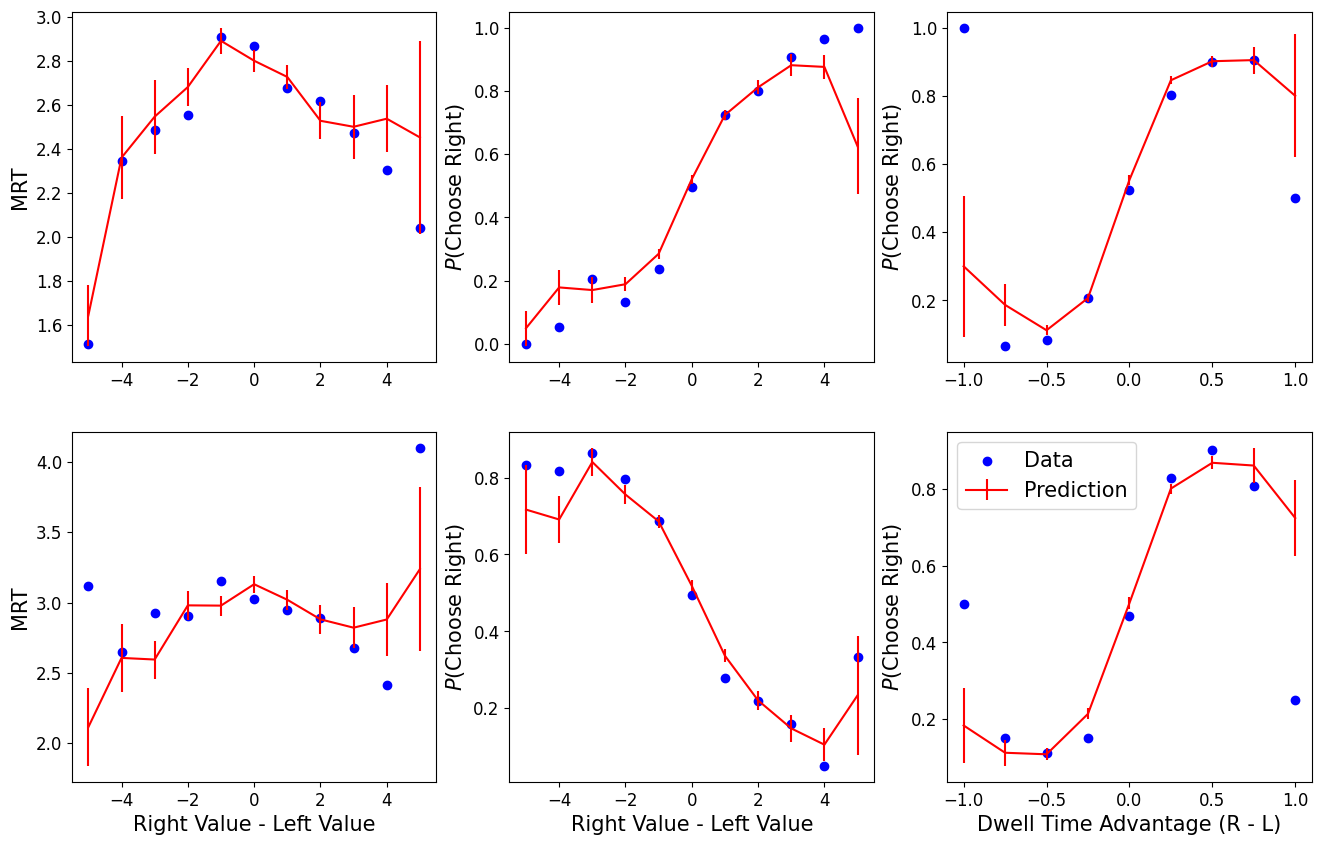

In [12]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_valuebased_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

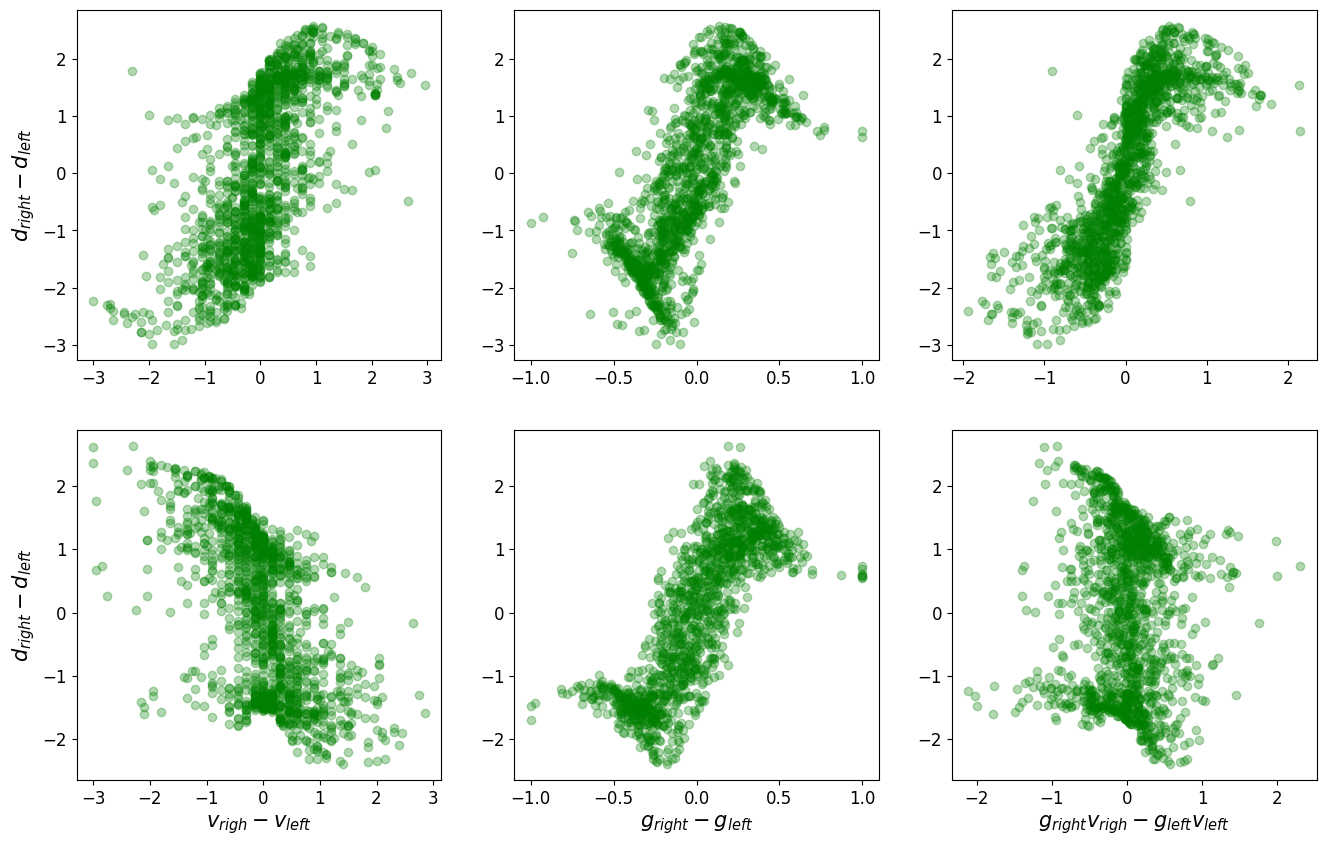

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_valuebased_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');